In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import device_put
import jax

Fetched MNIST data

In [2]:
data = fetch_openml('mnist_784', cache=False,as_frame=True)
target = data['target']

Data preprocessing is done in the cell below



In [3]:
data_np = data['data'].loc[:69999].to_numpy()
target_np = target.loc[:69999].to_numpy()
target_cat = []

for i in range (len(target_np)):
  t = target_np[i]
  t = int(t)
  arr = []
  for j in range(10):
    if(t == j):
      arr.append(1)
    else:
      arr.append(0)
  target_cat.append(arr)
target_cat = np.array(target_cat)

target_np = target.loc[:69999].to_numpy()
data_np /= 255.0
x_train, x_test, y_train, y_test = train_test_split(data_np, target_cat, test_size=0.20, random_state=42)

Data is transferred from **numpy** to **JAX.numpy**

In [4]:
x_train = device_put(x_train)
y_train = device_put(y_train)
x_test = device_put(x_test)
y_test = device_put(y_test)

Class for **Fully connected layer** and used the concept of **JAX Pytree** in method backwrd for gradient descent

In [5]:
class FCLayer:
  def __init__(self,input_layer, output_dimension):
    self.weights = np.random.randn(input_layer, output_dimension)/np.sqrt(input_layer+output_dimension)
    self.weights = device_put(self.weights)
    self.bias = np.random.randn(1,output_dimension)/np.sqrt(1+output_dimension)
    self.bias = device_put(self.bias)

  
  
  def forward(self, input_data):
    self.input_data = input_data
    output = jnp.dot(self.input_data,self.weights) + self.bias
    return output
  
  
  def backward(self, output_error, learning_rate):
    input_error = jnp.dot(output_error, self.weights.T)
    weight_error = jnp.dot(self.input_data.T, output_error)
    
    #self.weights = self.weights - learning_rate * weight_error
    #self.bias = self.bias - learning_rate *output_error
    self.weights = jax.tree_map(
        lambda weight, weight_error, learning_rate: weight - learning_rate * weight_error, self.weights, weight_error, learning_rate
    )       #used concept of pytree
    self.bias = jax.tree_map(
        lambda bias, output_error, learning_rate: bias - learning_rate * output_error, self.bias, output_error, learning_rate
    )     #used concept of JAX Pytree

    return input_error

Class for **activation layer** currently using **tanh activation function**

In [6]:
class ActivationLayer:
  def __init__(self):
    return
  
  def forward(self,input_data):
    self.input_data = input_data
    output = jnp.tanh(self.input_data) #tanh activation function
    #output = jnp.maximum(self.input_data, 0)  #Relu Activation function
    #output = 1 / (1 + jnp.exp(-1*self.input_data)) #sigmoid activation function
    return output
  
  def backward(self, output_error, learning_rate):#check later for input_data use
    grad = 1-jnp.tanh(self.input_data)**2     #derivative of tanh activation function
    #grad =  jnp.array(self.input_data >= 0).astype('int')     #derivative for ReLu function
    #grad = jnp.exp(-1*self.input_data) / (1 + jnp.exp(-1*self.input_data))**2    #dervative for sigmoid
    return grad*output_error


Class for complete Neural Network

In [12]:
class NeuralNetwork:
  
  def __init__(self):
    self.layers = []
  
  def add_layer(self, layer):
    self.layers.append(layer)
    
  def mse(self, y_true, y_pred):      #mean square error
    return jnp.mean(jnp.power(y_true-y_pred, 2));

  def gradient(self, y_true, y_pred):     #derivative for mean square error
    return 2*(y_pred-y_true)/y_pred.size;

  def soft_max_forward(self,input):       #softmax layer to improve performance of multi class classification
    exp = jnp.exp(input)
    output = exp/jnp.sum(exp)
    self.output = output
    return output
  
  def soft_max_backward(self, output_error, learning_rate):     #derivative for softmax layer
    input_error = jnp.zeros(output_error.shape)
    gradient = jnp.tile(self.output.T, 10)
    gradient = self.output * jnp.dot(output_error, np.identity(10)-gradient)
    return gradient


  def predict(self, input_data):
    input_size = len(input_data)
    res = []
    for i in range(input_size):
      error = 0
      out = input_data[i]
      for layer in self.layers:
        out = layer.forward(out)
      out = self.soft_max_forward(out)
      res.append(out)

    return res


  def fit(self, x_train, y_train,epochs, learning_rate):
    size_train = len(x_train)
    graph_data= []
    for epoch in range(epochs):
      err = 0
      for i in range(size_train):
        out = jnp.reshape(x_train[i],(1,784))
        for layer in self.layers:
          out = layer.forward(out)
        out = self.soft_max_forward(out)
        out = np.reshape(out, out.shape[1])
        
        error = self.mse(y_train[i],out)
        grad = self.gradient(y_train[i],out)

        grad = self.soft_max_backward(grad, learning_rate)
        for layer in reversed(self.layers):
          grad = layer.backward( grad, learning_rate)
        
        err += error
        #print(error) 
      err/=len(x_train)
      graph_data.append([epoch, err])
      #print('epoch %d/%d   error=%f' % (epoch, epochs, err))
      plt.plot(epoch, err)
    return graph_data


Please change the values in the cell below to manually change **no of neurons in hidden layers**

In [13]:
NN = NeuralNetwork()
layer1 = FCLayer(784,100)#hidden layer 1
NN.add_layer(layer1)
layer2 = ActivationLayer()
NN.add_layer(layer2)
layer3 = FCLayer(100,10)#hidden layer 2 also an additional layer softmax is added but no no class is written for it
NN.add_layer(layer3)

Please change the **learning rate**, **no of epochs**, **sample size** by changing size of *x_train* and *y_train* in NN.fit( ) function

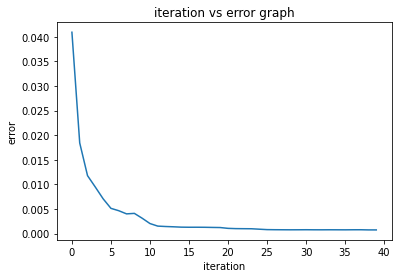

In [14]:
graph_data = NN.fit(x_train[:1000], y_train[:1000],epochs = 40, learning_rate = 0.5)
plt.xlabel("iteration")  # add X-axis label
plt.ylabel("error")  # add Y-axis label
plt.title("iteration vs error graph")
graph_data = np.array(graph_data)
plt.plot(graph_data[:,0],graph_data[:,1])

Please change **UPPER_BOUND** and **LOWER_BOUND** to evaluate the network with diff data

In [27]:
UPPER_BOUND = 200
LOWER_BOUND = 0
result = NN.predict(x_test[LOWER_BOUND:UPPER_BOUND])
result = np.reshape(result,(UPPER_BOUND - LOWER_BOUND,10))
res = np.argmax(result, axis = 1)
acc = 0
for i in range(UPPER_BOUND - LOWER_BOUND):
  ans = -1
  for j in range(len(y_test[i])):
    if y_test[LOWER_BOUND+i][j] == 1:
      ans = j
      break
  if ans == res[i]:
    acc+=1
print("Accuray of the Network is",acc/(UPPER_BOUND-LOWER_BOUND)*100)

Accuray of the Network is 89.5


Unable to discuss more classification metrics due to time constraints

Resources Used

1.   https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce6
2.   https://jax.readthedocs.io/en/latest/pytrees.html
3.   https://jax.readthedocs.io/en/latest/notebooks/quickstart.html
4.   https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/